In [1]:
import pandas as pd
import os
from subprocess import check_output
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print(check_output(['ls', './challenge_data']).decode('utf-8'))

learner_item_data.csv
test_groups.csv



Load data:

In [2]:
data_source = './challenge_data'
test_groups = pd.read_csv(os.path.join(data_source, 'test_groups.csv'))
learner_item = pd.read_csv(os.path.join(data_source, 'learner_item_data.csv'))

Inspecting data:

In [3]:
test_groups.head()

,test_group,uuid
0,control,6953977
1,test,1607983
2,control,6658627
3,control,4848596
4,test,1653336


In [4]:
learner_item.head()

,uuid,created_at,trainer_item_id
0,6953977,2017-01-16 10:54:43.386,0
1,6953977,2017-01-16 10:56:25.717,1
2,6953977,2017-01-16 10:55:50.642,2
3,6953977,2017-01-16 10:54:19.796,3
4,6953977,2017-01-16 10:55:10.654,1


# 1.

Convert column `created_at` to datetime.  Calculate duration between all user events. For each new user set back the duration to zero.

In [5]:
learner_item['created_at'] = pd.to_datetime(learner_item['created_at'])
sorted_learner = learner_item.sort_values(['uuid', 'created_at'], ascending=True)
sorted_learner['previous_uuid'] = sorted_learner['uuid'].shift()
sorted_learner = (sorted_learner
                .assign(time_diff = (sorted_learner['created_at'] - sorted_learner['created_at'].shift())
                .where(sorted_learner['uuid'] == sorted_learner['previous_uuid'], dt.timedelta(0))))

A sequence of events of the same user receives the same `session_id` if succesive events are not more than 60 minutes apart.

In [6]:
cond = ((sorted_learner['time_diff'] - sorted_learner['time_diff'].shift(1)).astype('timedelta64[m]') > 60) | (sorted_learner['previous_uuid'] != sorted_learner['uuid'])
sorted_learner['session_id'] = sorted_learner[cond].groupby(['uuid']).cumcount()+1
sorted_learner['session_id'] = sorted_learner['session_id'].fillna(method = 'ffill').astype(int)
sorted_learner['session_id'] = sorted_learner['uuid'].map(str) + '_' + sorted_learner['session_id'].map(str)
sorted_learner.head()

,uuid,created_at,trainer_item_id,previous_uuid,time_diff,session_id
689933,2990,2016-12-25 11:27:22.905,2,NaN,0 days 00:00:00,2990_1
689927,2990,2016-12-25 11:27:28.985,0,2990.0,0 days 00:00:06.080000,2990_1
689931,2990,2016-12-25 11:27:33.603,3,2990.0,0 days 00:00:04.618000,2990_1
689929,2990,2016-12-25 11:27:38.010,1,2990.0,0 days 00:00:04.407000,2990_1
689544,2990,2016-12-28 09:40:57.271,604,2990.0,2 days 22:13:19.261000,2990_2


# 2.

In [7]:
def duration(x):
    """Helper function to calculate duration of a session."""
    return max(x) - min(x)

Calulate individual session lenghts:

In [8]:
agg_session_length = sorted_learner.groupby(['session_id']).agg({"created_at": [duration]})

Visualize distributions of session lengths as histogram:

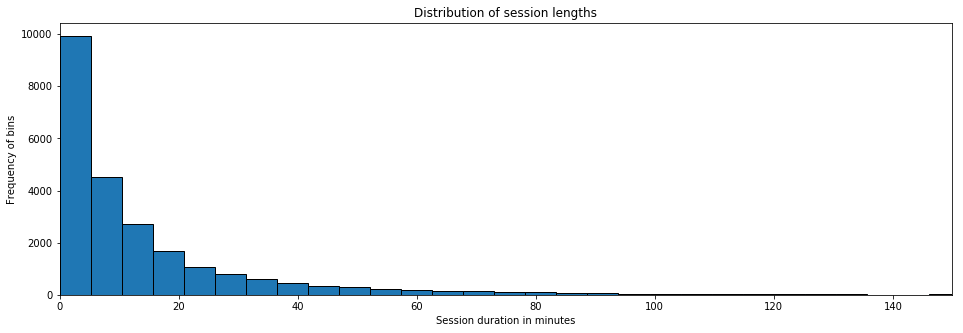

In [9]:
y = agg_session_length.reset_index()['created_at'].values.squeeze()/np.timedelta64(1, 'm')
plt.figure(figsize = (16,5))
plt.title('Distribution of session lengths')
plt.xlabel('Session duration in minutes')
plt.ylabel('Frequency of bins')
plt.hist(y, normed=False, bins=2000, edgecolor='black')
plt.xlim([0,150])
plt.show()

Determine number of user lessons per day:

In [10]:
sorted_learner['date'] = sorted_learner['created_at'].dt.date
user_lessons_day = pd.DataFrame(sorted_learner.groupby(['uuid', 'date'])['session_id'].nunique()).reset_index()

In [11]:
user_lessons_day.head()

,uuid,date,session_id
0,2990,2016-12-25,1
1,2990,2016-12-28,1
2,2990,2016-12-31,1
3,2990,2017-01-01,3
4,2990,2017-01-02,1


Determine number of users who have done several lessons per day. 

In [12]:
mult_session_users = user_lessons_day[user_lessons_day['session_id']>1]['uuid'].nunique()
mult_session_users

845

Total number of users:

In [13]:
all_users = user_lessons_day['uuid'].nunique()

In [14]:
print('Percentage of users who have done at least once more than one session per day: {} %'
      .format(mult_session_users/all_users * 100))

Percentage of users who have done at least once more than one session per day: 11.4887831407206 %


Visualize distribution of user sessions per day as histogram.

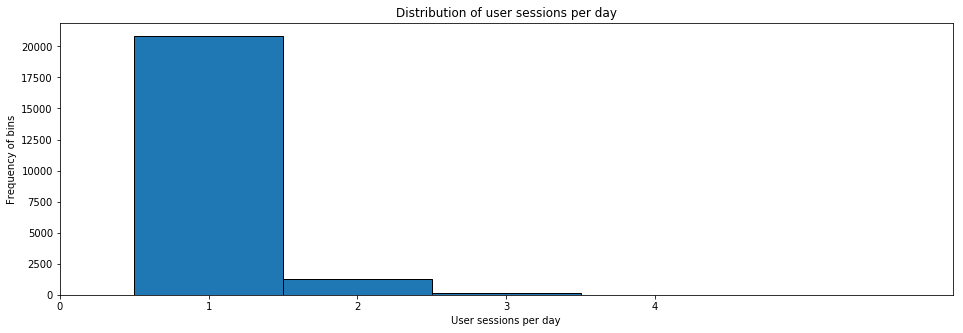

In [15]:
lessons_per_day = user_lessons_day['session_id'].nunique()
bins = np.arange(lessons_per_day) - 0.5
plt.figure(figsize = (16,5))
plt.hist(user_lessons_day['session_id'], normed=False, bins=bins, edgecolor='black')
plt.xlim([0,user_lessons_day['session_id'].nunique()+1])
plt.xticks(np.arange(lessons_per_day))
plt.title('Distribution of user sessions per day')
plt.xlabel('User sessions per day')
plt.ylabel('Frequency of bins')
plt.show()

# 3.

#### First, compare the percentage of users who do multiple sessions in each of the two groups.

Number of users in control group who have done at least once several sessions per day:

In [16]:
mult_session_control = (user_lessons_day
                        .loc[(user_lessons_day['session_id']>1) & (user_lessons_day['uuid']
                        .isin(test_groups.uuid[test_groups['test_group']=='control']))]['uuid']
                        .nunique())

In [17]:
mult_session_control

481

Total number of users in control group:

In [18]:
cnt_users_control = (user_lessons_day
                     .loc[user_lessons_day['uuid']
                     .isin(test_groups.uuid[test_groups['test_group']=='control'])]['uuid']
                     .nunique())

In [19]:
cnt_users_control

4309

In [20]:
print('Percentage of users in control group who have done at least once more than one session per day: {} %'
       .format(mult_session_control/cnt_users_control * 100))

Percentage of users in control group who have done at least once more than one session per day: 11.162682757020189 %


Number of users in test group who have done at least once several sessions per day:

In [21]:
mult_session_test = (user_lessons_day
                     .loc[(user_lessons_day['session_id']>1) & (user_lessons_day['uuid']
                     .isin(test_groups.uuid[test_groups['test_group']=='test']))]['uuid']
                     .nunique())

In [22]:
mult_session_test

364

Number of users in test group:

In [23]:
cnt_users_test = (user_lessons_day
                  .loc[user_lessons_day['uuid']
                  .isin(test_groups.uuid[test_groups['test_group']=='test'])]['uuid']
                  .nunique())

In [24]:
cnt_users_test

3046

In [25]:
print('Percentage of users in test group who have done at least once more than one session per day: {} %'
        .format(mult_session_test/cnt_users_test * 100))

Percentage of users in test group who have done at least once more than one session per day: 11.950098489822718 %


#### Compare median session length in both groups.

Median session length in control group:

In [26]:
median_length_control = (sorted_learner[sorted_learner['uuid']
               .isin(test_groups.uuid[test_groups['test_group']=='control'])]
               .groupby(['session_id']).agg({"created_at": [duration]})
               .median())

In [27]:
median_length_control

created_at  duration   00:07:08.887500
dtype: timedelta64[ns]

Median session length in test group:

In [28]:
median_length_test = (sorted_learner[sorted_learner['uuid']
                .isin(test_groups.uuid[test_groups['test_group']=='test'])]
                .groupby(['session_id']).agg({"created_at": [duration]})
                .median())

In [29]:
median_length_test

created_at  duration   00:06:58.847000
dtype: timedelta64[ns]

In [30]:
from IPython.display import HTML, display
from prettytable import PrettyTable
t = PrettyTable(["",'Control group', 'Test group'])
t.add_row(["Median length in seconds",median_length_control['created_at', 'duration']/np.timedelta64(1, 's'), median_length_test['created_at', 'duration']/np.timedelta64(1, 's')])
t.add_row(["Multiple sessions percentage",' {0:.4g} %'.format(mult_session_control/cnt_users_control * 100) ,' {0:.4g} %'.format(mult_session_test/cnt_users_test * 100)])
print(t)

+------------------------------+---------------+------------+
|                              | Control group | Test group |
+------------------------------+---------------+------------+
|   Median length in seconds   |    428.8875   |  418.847   |
| Multiple sessions percentage |     11.16 %   |   11.95 %  |
+------------------------------+---------------+------------+


11.16 % in control group have done multiple lessons and 11.95 % in the test group. The difference is only small. On the other hand is the median session length shorter in the test group than in the control group (07:08 min vs. 06:58 min). 
Based on the experiments introducing the feature doesn't seem to be adivisable. There is a minimal higher percentage of multiple lessons on one day but the reason for the difference could be attributed to general differences between test and control group. The slightly higher percentage in multiple lessons can't prevent that the average usage time (represented by the median) is decling. 
To validate the results test and control groups could be switched. If further exploration reveals that the new feature is popular in a subgroup it could be introduced as an optional feature which can be activated by interested users.